In [ ]:
#------------------Ozone dataset---------------------

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

data = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/LAozone.data')
print(f"data: {data.shape[0]} rows and {data.shape[1]} columns")
#data.head()

data: 330 rows and 10 columns


In [ ]:
#We need to employ good practices and this means freezing up some of the testing data, separate from the training and validation data that will be used for CV.

from sklearn.model_selection import train_test_split, KFold

# Convert from DataFrame to array
y = data['ozone'].values                          #The .values attribute converts the 'ozone' column (also called the target variable which typically contains the variable I am trying to predict) from a Pandas Series into a NumPy array
X = data.iloc[:,1:10].astype(float).values        #data.iloc[:,1:10] accesses all the rows and the columns from 1 to 9 from the DataFrame data; .astype(float) converts the data type of these columns to float if they aren't already.
                                                  #This NumPy array X will be your input features, which are the independent variables used for predicting the target
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

print("Training samples: ", len(y_train))
print("Testing samples: ", len(y_test))
#print(y)

Training samples:  247
Testing samples:  83


In [ ]:
#Lets pre-process the data as many estimators can be thrown of by large differences in of scale and variations between the features.
#We can easily account for this in our estimators by simply normalizing the feature columns and removing averages.

from sklearn import preprocessing

#The goal here is to make sure that all the features have zero mean and unit variance preventing features with large values from dominating the model compared to features with smaller values.
scaler = preprocessing.StandardScaler().fit(X_train)   #This creates a StandardScaler object from the sklearn.preprocessing module, which will calculate the mean and standard deviation for each feature in the training data (X_train).
X_train = scaler.transform(X_train)                    #Now, we use the apply the "scaler" to "X_train". It subtracts the mean and divides by the standard deviation for each feature to center and scale it. After this, the features will have a mean of 0 and a variance of 1.
X_test = scaler.transform(X_test)

#We also center the target variable
ymean = np.mean(y_train)
y_train = y_train - ymean
y_test = y_test - ymean

print(ymean)

-2.8766912378951425e-17


In [ ]:
#--------------------------------------------EVALUATED----------------------------------------------------------

from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

clf = tree.DecisionTreeRegressor()    # Model that was asked to be used

# Define the hyperparameter grid with correct criterion names
param_grid = {
    'max_depth': range(2, 10, 1),                      # Maximum depth of the tree
    'min_samples_split': range(2, 10, 1),              # Minimum number of samples required to split a node
    'min_samples_leaf': range(2, 10, 1),               # Minimum number of samples required in each leaf node
    'max_features': [None, 'auto', 'sqrt', 'log2'],    # Number of features to consider when looking for the best split
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']  # Correct split quality function names
}

# Set up the GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)  # Fit the model using GridSearchCV, here us where the best hyperparameters are identified!

# Predict, using the best model found using CV
y_pred_test = grid_search.predict(X_test)
y_pred_train = grid_search.predict(X_train)

#MSE
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)

print("Best hyperparameters found: ", grid_search.best_params_)
print("Mean Squared Error for the test:", mse_test)
print("Mean Squared Error for the train:", mse_train)


Best hyperparameters found:  {'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 3}
Mean Squared Error for the test: 23.3442694724006
Mean Squared Error for the train: 13.695989451526485


Text(0.5, 1.0, 'Prediction Performance')

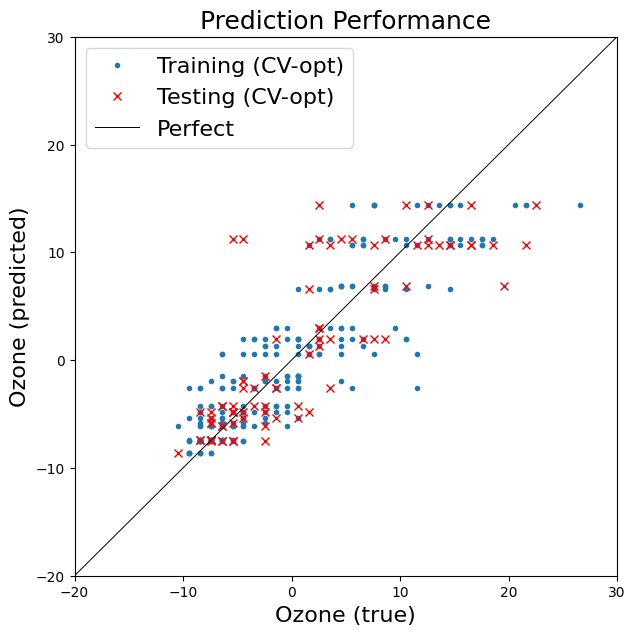

In [ ]:
import matplotlib.pyplot as plt

# Visualize
plt.figure(figsize=(7, 7))
plt.plot(y_train, y_pred_train, '.', label='Training (CV-opt)')
plt.plot(y_test, y_pred_test, '.r', label='Testing (CV-opt)', marker='x')
plt.plot([-40, 40], [-40, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([-20, 30, -20, 30])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

#------REMEMBER: We had normalized the data thats why there are alot of negative values!!!--------------------

Mean Squared Error for the test: 18.894443373493974
Mean Squared Error for the train: 2.4623303643724586


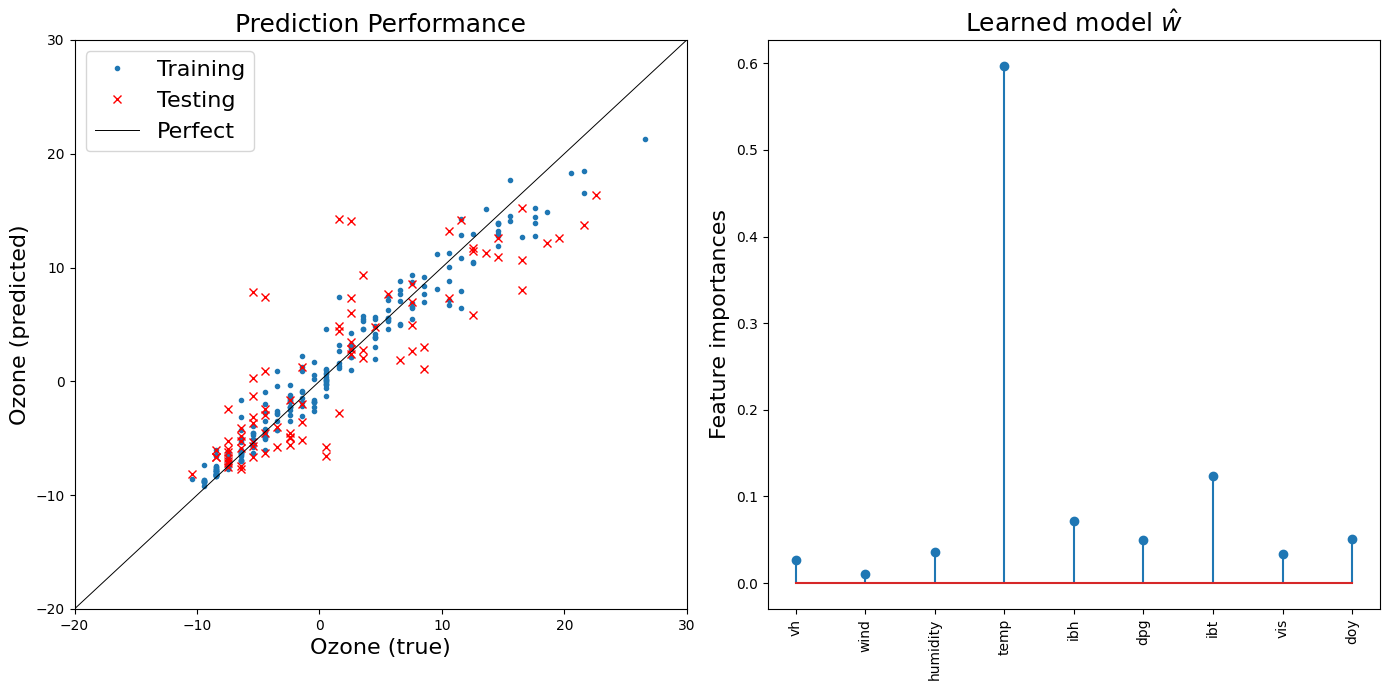

In [ ]:
#Now comes the cool part, we basically have seen that the regression trees are okay but not the best, the idea is to use multiple regression trees trained on bootstrapped datasets to run a random forest model
#The random forest model works on the principle that combines multiple decision trees to improve predictive performance. The code is super similar to what we saw before.

from sklearn import ensemble

rf = ensemble.RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_train_forest = rf.predict(X_train)
y_pred_test_forest = rf.predict(X_test)

# Visualize
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(y_train , y_pred_train_forest , '.', label='Training')
plt.plot(y_test , y_pred_test_forest, '.r', label='Testing', marker='x')
plt.plot([-40, 40], [-40, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([-20, 30, -20, 30])
plt.xlabel('Ozone (true)', fontsize=16)
plt.ylabel('Ozone (predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)

# Cool new little part that tells us which feature is the most important
plt.subplot(122)
plt.stem(rf.feature_importances_)
plt.title(r'Learned model $\hat{w}$', fontsize=18)
plt.ylabel('Feature importances', fontsize=16)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')
plt.tight_layout()

#Errors
mse_test_forest = mean_squared_error(y_test, y_pred_test_forest)
mse_train_forest = mean_squared_error(y_train, y_pred_train_forest)
print("Mean Squared Error for the test:", mse_test_forest)
print("Mean Squared Error for the train:", mse_train_forest)